In [1]:
import os
import webbrowser


from typing import Annotated, Literal
from typing_extensions import TypedDict

from dotenv import load_dotenv
from src.tools.gvm_workflow import GVMWorkflow
from src.tools.gvm_results import ResultManager

from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent, ToolNode
from langchain_core.runnables.graph_mermaid import draw_mermaid_png

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.types import interrupt
from langgraph.checkpoint.memory import MemorySaver


load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
        model = "gpt-4o-mini",
        temperature=0.1,
        max_completion_tokens=None,
        timeout=None,
        api_key=api_key,
        )


In [3]:
try:
    if api_key is not None:
        print("API key is loaded sucessfully")
except Exception as e:
    print(f"Erro {e}")

API key is loaded sucessfully


In [4]:
query = input("User: ")

In [5]:
def get_response_from_openai(message):

    llm = ChatOpenAI(
        model = "gpt-4o-mini",
        temperature=0.1,
        max_completion_tokens=None,
        timeout=None,
        api_key=api_key,
        )
    
    response = llm.invoke(message)
    
    return response

In [6]:
@tool
def get_OpenVAS_results(question: str):
    """
    This tool assists in interpreting an OpenVAS scan result. It helps automate the analysis and understanding 
    of the vulnerability data extracted from the OpenVAS scan results in the string
    """
    result_manager = ResultManager()
   
    context =  result_manager.result()
   
    messages = [
        SystemMessage(content="""You are a cybersecurity assistant specializing in network scanning 
                      and penetration testing. With expert knowledge of OpenVAS, a powerful vulnerability 
                      scanning tool, your role is to interpret everything that comes within the string of 
                      an XML result converted from an OpenVAS scan. Do not skip any detail—automatically 
                      analyze and extract all relevant vulnerability data from the string, ensuring nothing 
                      is overlooked. Your task is to ensure that every piece of information within the OpenVAS 
                      scan result is processed thoroughly and accurately, providing users with complete insights into the scans
                      findings. Be emphatic in your approach, making sure no important data is missed, and offering precise 
                      analysis for effective vulnerability assessment. You have to hide the response of result_str
                      
                      You are a cybersecurity assistant specializing in vulnerability analysis and reporting. 
                      Your task is to provide detailed information about detected vulnerabilities in a structured format.

                      When responding, follow this template and replace the placeholders with the appropriate values:

                        Vulnerability: [Name of the vulnerability, typically from databases like CVE, descriptive and concise]

                        ID: [Unique identifier for the vulnerability within the reporting system]
                        Host: _[IP address of the affected host, optionally including an identifier such as "_gateway" or "webserver"]
                        Port: [Affected port number and protocol (e.g., 443/tcp)]
                        CVSS Base Score: [Severity score based on the CVSS scale, indicating if it is low, medium, high, or critical]
                        Description: [Brief technical explanation of the vulnerability, including its cause and potential impacts, such as remote code execution, XSS, SQL injection, etc.]
                        Solution: [Recommended mi    response = get_response_from_openai(messages)
tigation, such as updating software, applying patches, or configuring security settings]
                        References: [List of relevant references, such as CVEs, links to official documentation, or bug tracking tickets]

                        Ensure responses are concise, technical, and consistently formatted. After following the vulnerability reporting template, provide additional suggestions for solutions 
                        and routines to enhance system security. These suggestions can include security best practices, configuration changes, regular updates, and proactive monitoring routines 
                        to ensure the overall safety and resilience of the system. Ensure that all detected vulnerabilities are processed and reported. No vulnerability should be left unaddressed. 
                        If any vulnerability is missed, trigger a re-evaluation or notify the user."""),
        HumanMessage(content=f"Please analyze the following OpenVAS scan result: {context}, using{question}")
    ]
    
    response = get_response_from_openai(messages)
    
    return response

In [7]:
@tool
def create_OpenVAS_tasks(question: str):
    """
    This tool helps create tasks in OpenVAS, a vulnerability scanning tool.
    It will assist in automating task creation for network scans and pentesting tasks within OpenVAS.
    """
    workflow = GVMWorkflow()
    
    context =  workflow.run()
   
    messages = [
        SystemMessage(content="""You are a cybersecurity assistant specialized in network scanning and penetration testing. 
                                  You are an expert in using OpenVAS, a powerful vulnerability scanning tool, and have in-depth knowledge 
                                  of its functionalities, including task automation and management. Your role is to assist with automating 
                                  the creation of tasks in OpenVAS, guiding the user through setting up scans, configuring targets, 
                                  and scheduling tasks to ensure optimal vulnerability assessments. You should provide clear, concise instructions 
                                  and troubleshooting tips for configuring OpenVAS tasks, helping users streamline their security operations effectively. 
                                  Additionally, you should offer suggestions on best practices for network scanning and pentesting using OpenVAS, 
                                  based on the user's specific needs."""),
        HumanMessage(content=f"Execute the following task: {context}, using{question}")
    ]
    
    response = get_response_from_openai(messages)
    
    return response

In [8]:
@tool
def open_browser(porta=9392):
    """
    This tool helps launch the GUI of OpenVAS, a vulnerability scanning tool.  
    It will assist in automating the process of opening and accessing the OpenVAS 
    graphical interface for managing scans and security assessments.  
    """

    url = f"http://127.0.0.1:{porta}/"
    webbrowser.open(url)
    print(f"Opening {url} in the browser...")

In [9]:
members = ["tasker", "resulter", "human"]

options = members + ["FINISH"]

checkpointer = MemorySaver()

In [10]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [11]:
class Router(TypedDict):

    next: Literal[*options]


class State(MessagesState):
    summary: str
    next: str


In [12]:
def human_editing(state: State):

    result = interrupt(
        
        {
            "task": "Review the output from the LLM and make any necessary edits.",
            "llm_generated_summary": state["messages"][-1].content
        }
    )

    return Command(update={"messages": HumanMessage(result["edited_text"]), "next": "supervisor"}, goto="supervisor")

In [13]:
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [14]:
task_agent = create_react_agent(llm, 
                                tools=[create_OpenVAS_tasks, open_browser], 
                                prompt="""You are an automation agent responsible for task creation 
                                and workflow management in OpenVAS. Your goal is to optimize the execution 
                                of scans, open the OpenVAS GUI in the browser, and ensure smooth task management.
                                Strictly follow security and compliance protocols.""")

def task_node(state: State) -> Command[Literal["supervisor", "call_tool"]]:
    result = task_agent.invoke(state)
    print(result)
    if result["messages"][-1].tool_calls:
        return Command(
            update={"messages": [
                AIMessage(content=result["messages"][-1].content, name="tasker")
            ],
            "next": "tasker"
            },
            goto="call_tool"
        )
    else: 
        return Command(
            update={
             "messages": [
                AIMessage(content=result["messages"][-1].content, name="tasker")
            ]
        },
        goto="supervisor"  
    )

    

In [15]:
result_agent = create_react_agent(llm, 
                                  tools=[get_OpenVAS_results], 
                                  prompt="""You are an analysis agent responsible for reviewing and interpreting
                                            OpenVAS scan results. Your goal is to process reports, identify critical vulnerabilities, 
                                            and provide clear summaries of key findings. Highlight security risks, suggest mitigation strategies, 
                                            and ensure the information is actionable for users. Strictly follow security and compliance protocols.""")

def result_node(state: State) -> Command[Literal["supervisor", "call_tool"]]:
    result = result_agent.invoke(state)
    if result["messages"][-1].tool_calls:
        return Command(
            update={"messages": [
                AIMessage(content=result["messages"][-1].content, name="resulter")
            ],
            "next": "resulter"
            },
            goto="call_tool"
        )
    else: 
        return Command(
            update={
             "messages": [
                AIMessage(content=result["messages"][-1].content, name="resulter")
            ]
        },
        goto="supervisor"  
    )

In [16]:
toolkit = [get_OpenVAS_results, open_browser, create_OpenVAS_tasks]

In [17]:
tool_node = ToolNode(toolkit)


In [18]:
builder = StateGraph(State)
builder.set_entry_point("supervisor")

builder.add_node("supervisor", supervisor_node)
builder.add_node("tasker", task_node)
builder.add_node("resulter", result_node)
builder.add_node("call_tool", tool_node)
builder.add_node("human", human_editing)

builder.add_conditional_edges("call_tool", lambda x: x["next"], {"resulter":"resulter", "tasker":"tasker"})
builder.add_edge("human", "supervisor")

graph = builder.compile(checkpointer=checkpointer)


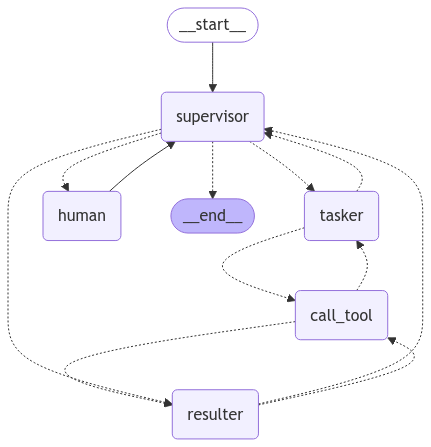

In [19]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
thread_config = {"configurable": {"thread_id": "some_id"}}

In [21]:
for s in graph.stream(
    {"messages": [("user", query)]}, subgraphs=True,
    config=thread_config
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'tasker'}})
----
(('tasker:91c987d8-944d-18f0-a60a-0f621566d11b',), {'agent': {'messages': [AIMessage(content='Para analisar uma task no OpenVAS, você pode fornecer mais detalhes sobre a task que deseja analisar? Por exemplo, você gostaria de verificar os resultados de uma análise específica, revisar as configurações da task ou algo mais?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 194, 'total_tokens': 240, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-9fef0464-1254-49f7-9f8f-d0377c3a31fd-0', usage_metadata={'input_tokens': 194, 'output_tokens': 46, 'total_tokens': 240, 'input_token_details': {'audio'